In [12]:
import pandas as pd
import time
import numpy as np
import plotly.express as px
import datashader as ds
from colorcet import fire
import datashader.transfer_functions as tf

In [13]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data1.csv"
)
dff = (
    df.query("Lat < 40.82")
    .query("Lat > 40.70")
    .query("Lon > -74.02")
    .query("Lon < -73.91")
)

import datashader as ds

cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(dff, x="Lon", y="Lat")
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords["Lat"].values, agg.coords["Lon"].values
# Corners of the image, which need to be passed to mapbox
coordinates = [
    [coords_lon[0], coords_lat[0]],
    [coords_lon[-1], coords_lat[0]],
    [coords_lon[-1], coords_lat[-1]],
    [coords_lon[0], coords_lat[-1]],
]

# from colorcet import fire
# import datashader.transfer_functions as tf

# img = tf.shade(agg, cmap=fire)[::-1].to_pil()

# import plotly.express as px

# Trick to create rapidly a figure with mapbox axes
# fig = px.scatter_mapbox(dff[:1], lat="Lat", lon="Lon", zoom=12)
# Add the datashader image as a mapbox layer image
# fig.update_layout(
#    mapbox_style="carto-darkmatter",
#    mapbox_layers=[{"sourcetype": "image", "source": img, "coordinates": coordinates}],
# )
## Zeige die Karte nicht an, sondern weil sonst jupyterlab abstürzt
# fig.show()


In [14]:
# Function to simulate filtering data based on a zoom level to mimic LOD
def filter_data(df, zoom_level):
    if zoom_level < 10:
        # At low zoom levels, sample the dataset to reduce size
        frac = 1 / (11 - zoom_level)  # Less detail as we zoom out
        return df.sample(frac=frac)
    else:
        # At high zoom levels, use the full dataset
        return df


# Function to simulate the rendering of a subset of the data and measure time
def benchmark_data_size(df, fraction):
    start_time = time.time()

    # Reduce the dataset according to the fraction specified
    dff = df.sample(frac=fraction) if fraction < 1 else df

    # Visualization code with datashader
    cvs = ds.Canvas(plot_width=500, plot_height=500)
    agg = cvs.points(dff, "Lon", "Lat")
    img = tf.shade(agg, cmap=fire)[::-1].to_pil()

    end_time = time.time()
    return end_time - start_time  # Return the time taken to simulate rendering


# Function to simulate rendering the visualization and measure time
def benchmark_rendering(df, zoom_level, width=500, height=500):
    start_time = time.time()

    # Filter data based on zoom level
    dff = filter_data(df, zoom_level)

    # Visualization code
    cvs = ds.Canvas(plot_width=width, plot_height=height)
    agg = cvs.points(dff, "Lon", "Lat")
    img = tf.shade(agg, cmap=fire)[::-1].to_pil()

    # Using Plotly to display the data - not the actual rendering time
    fig = px.scatter_mapbox(dff[:1], lat="Lat", lon="Lon", zoom=zoom_level)
    fig.update_layout(
        mapbox_style="carto-darkmatter",
        mapbox_layers=[
            {
                "sourcetype": "image",
                "source": img,
                "coordinates": [
                    [-74.02, 40.70],
                    [-73.91, 40.70],
                    [-73.91, 40.82],
                    [-74.02, 40.82],
                ],
            }
        ],
    )
    # Note: This will not display in a non-interactive environment
    # fig.show()

    end_time = time.time()
    return end_time - start_time  # Return the time taken to simulate rendering

In [15]:
# Load the dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data1.csv"
)

In [16]:
# Benchmark performance at different zoom levels
zoom_levels = [5, 8, 10, 12, 15]
for zoom in zoom_levels:
    time_taken = benchmark_rendering(df, zoom)
    print(f"Time taken to render at zoom level {zoom}: {time_taken:.4f} seconds")

Time taken to render at zoom level 5: 0.1185 seconds
Time taken to render at zoom level 8: 0.1290 seconds
Time taken to render at zoom level 10: 0.0470 seconds
Time taken to render at zoom level 12: 0.0505 seconds
Time taken to render at zoom level 15: 0.0550 seconds


In [17]:
# Benchmark performance at different zoom levels
zoom_levels = [5, 8, 10, 12, 15]
for zoom in zoom_levels:
    time_taken = benchmark_rendering(df, zoom, width=10000, height=10000)
    print(f"Time taken to render at zoom level {zoom}: {time_taken:.4f} seconds")

Time taken to render at zoom level 5: 5.4258 seconds
Time taken to render at zoom level 8: 5.9222 seconds
Time taken to render at zoom level 10: 5.5894 seconds
Time taken to render at zoom level 12: 5.7893 seconds
Time taken to render at zoom level 15: 5.6416 seconds


In [18]:
def benchmark_plotly_rendering(df, zoom, width=500, height=500):
    start_time = time.time()

    # Create Plotly figure using native scatter
    fig = px.scatter_mapbox(
        df, lat="Lat", lon="Lon", zoom=zoom, height=height, width=width
    )
    fig.update_layout(mapbox_style="carto-darkmatter")
    fig.update_traces(marker=dict(size=3))

    # We don't actually display the figure in this benchmarking function.
    # In a live environment, you would use fig.show()

    end_time = time.time()
    return end_time - start_time  # Return the time taken for this rendering approach


# Benchmark performance at different zoom levels
zoom_levels = [5, 8, 10, 12, 15]
for zoom in zoom_levels:
    time_taken = benchmark_plotly_rendering(df, zoom)
    print(
        f"Time taken to render at zoom level {zoom} with Plotly native scatter: {time_taken:.4f} seconds"
    )

Time taken to render at zoom level 5 with Plotly native scatter: 0.0895 seconds
Time taken to render at zoom level 8 with Plotly native scatter: 0.0510 seconds
Time taken to render at zoom level 10 with Plotly native scatter: 0.0505 seconds
Time taken to render at zoom level 12 with Plotly native scatter: 0.0550 seconds
Time taken to render at zoom level 15 with Plotly native scatter: 0.0505 seconds


In [19]:
# Data size benchmarks
fractions = [
    0.01,
    0.05,
    0.1,
    0.5,
    1,
    1000000000000,
]  # Fractions of the original data size to use in the benchmark
for fraction in fractions:
    time_taken = benchmark_data_size(df, fraction)
    data_size = len(df) * fraction
    print(
        f"Time taken to render with {data_size:.0f} data points (fraction: {fraction}): {time_taken:.4f} seconds"
    )

Time taken to render with 15114 data points (fraction: 0.01): 0.0580 seconds
Time taken to render with 75572 data points (fraction: 0.05): 0.0595 seconds
Time taken to render with 151144 data points (fraction: 0.1): 0.0625 seconds
Time taken to render with 755722 data points (fraction: 0.5): 0.1275 seconds
Time taken to render with 1511443 data points (fraction: 1): 0.0280 seconds
Time taken to render with 1511443000000000000 data points (fraction: 1000000000000): 0.0275 seconds


In [20]:
# Benchmark rendering with actual larger datasets by duplicating the dataframe
multiples = [1, 2, 5, 10, 100]  # Multiples of the original data size
for multiple in multiples:
    # Concatenate the dataframe to itself 'multiple' times
    larger_df = pd.concat([df] * multiple)
    time_taken = benchmark_data_size(larger_df, 1)
    data_size = len(larger_df)
    print(
        f"Time taken to render with {data_size} data points (multiple: {multiple}): {time_taken:.4f} seconds"
    )

Time taken to render with 1511443 data points (multiple: 1): 0.0330 seconds
Time taken to render with 3022886 data points (multiple: 2): 0.0445 seconds
Time taken to render with 7557215 data points (multiple: 5): 0.0706 seconds
Time taken to render with 15114430 data points (multiple: 10): 0.1510 seconds
Time taken to render with 151144300 data points (multiple: 100): 1.1973 seconds


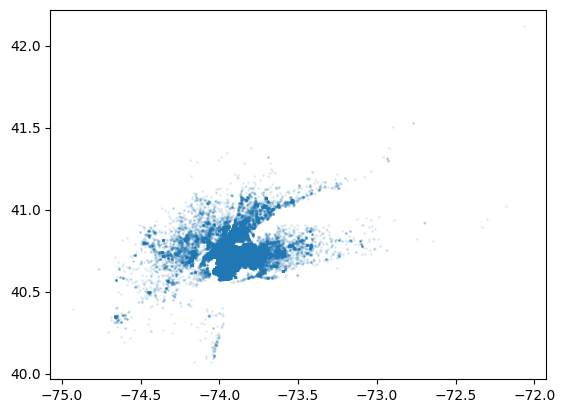

Matplotlib rendering time: 0.8733 seconds
Datashader rendering time: 3.7406 seconds


In [21]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf

# Load the dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/plotly/datasets/master/uber-rides-data1.csv"
)


# Define the rendering functions for comparison
def render_matplotlib(df):
    plt.scatter(df["Lon"], df["Lat"], s=1, alpha=0.1)
    plt.show()


def render_datashader(df):
    cvs = ds.Canvas(plot_width=500, plot_height=500)
    agg = cvs.points(df, "Lon", "Lat")
    img = tf.shade(agg, cmap=["lightblue", "darkblue"])
    img.to_pil().show()


# Benchmarking function
def benchmark_rendering(df, rendering_function):
    start_time = time.time()
    rendering_function(df)
    end_time = time.time()
    return end_time - start_time


# Perform benchmarking
matplotlib_time = benchmark_rendering(df, render_matplotlib)
datashader_time = benchmark_rendering(df, render_datashader)

print(f"Matplotlib rendering time: {matplotlib_time:.4f} seconds")
print(f"Datashader rendering time: {datashader_time:.4f} seconds")

In [22]:
import seaborn as sns

# Import the dataset
diamonds = sns.load_dataset("diamonds")

diamonds.shape
(53940, 10)

print(diamonds.head())

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [23]:
import matplotlib.pyplot as plt

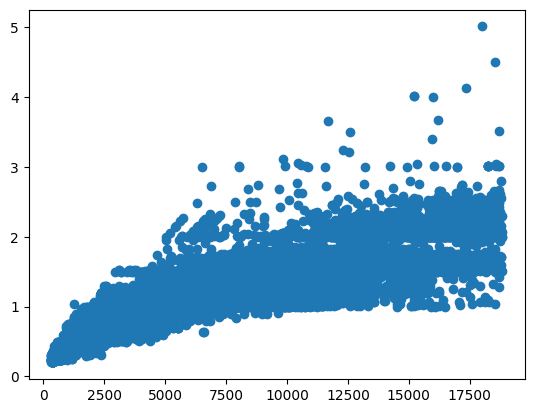

In [24]:
# Measure Matplotlib
plt.scatter(
    diamonds["price"],
    diamonds["carat"],
)
# stop the timer
plt.show()

In [25]:
# Measure Plotly
fig = px.scatter(data_frame=diamonds, x="price", y="carat")

fig.show()